In [421]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from sklearn.metrics import precision_recall_fscore_support as p_r_f_s
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as conf

from sklearn.ensemble import RandomForestClassifier as RF

In [234]:
data = pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### A pair plot is processed below to evaluate the main relation between the variables

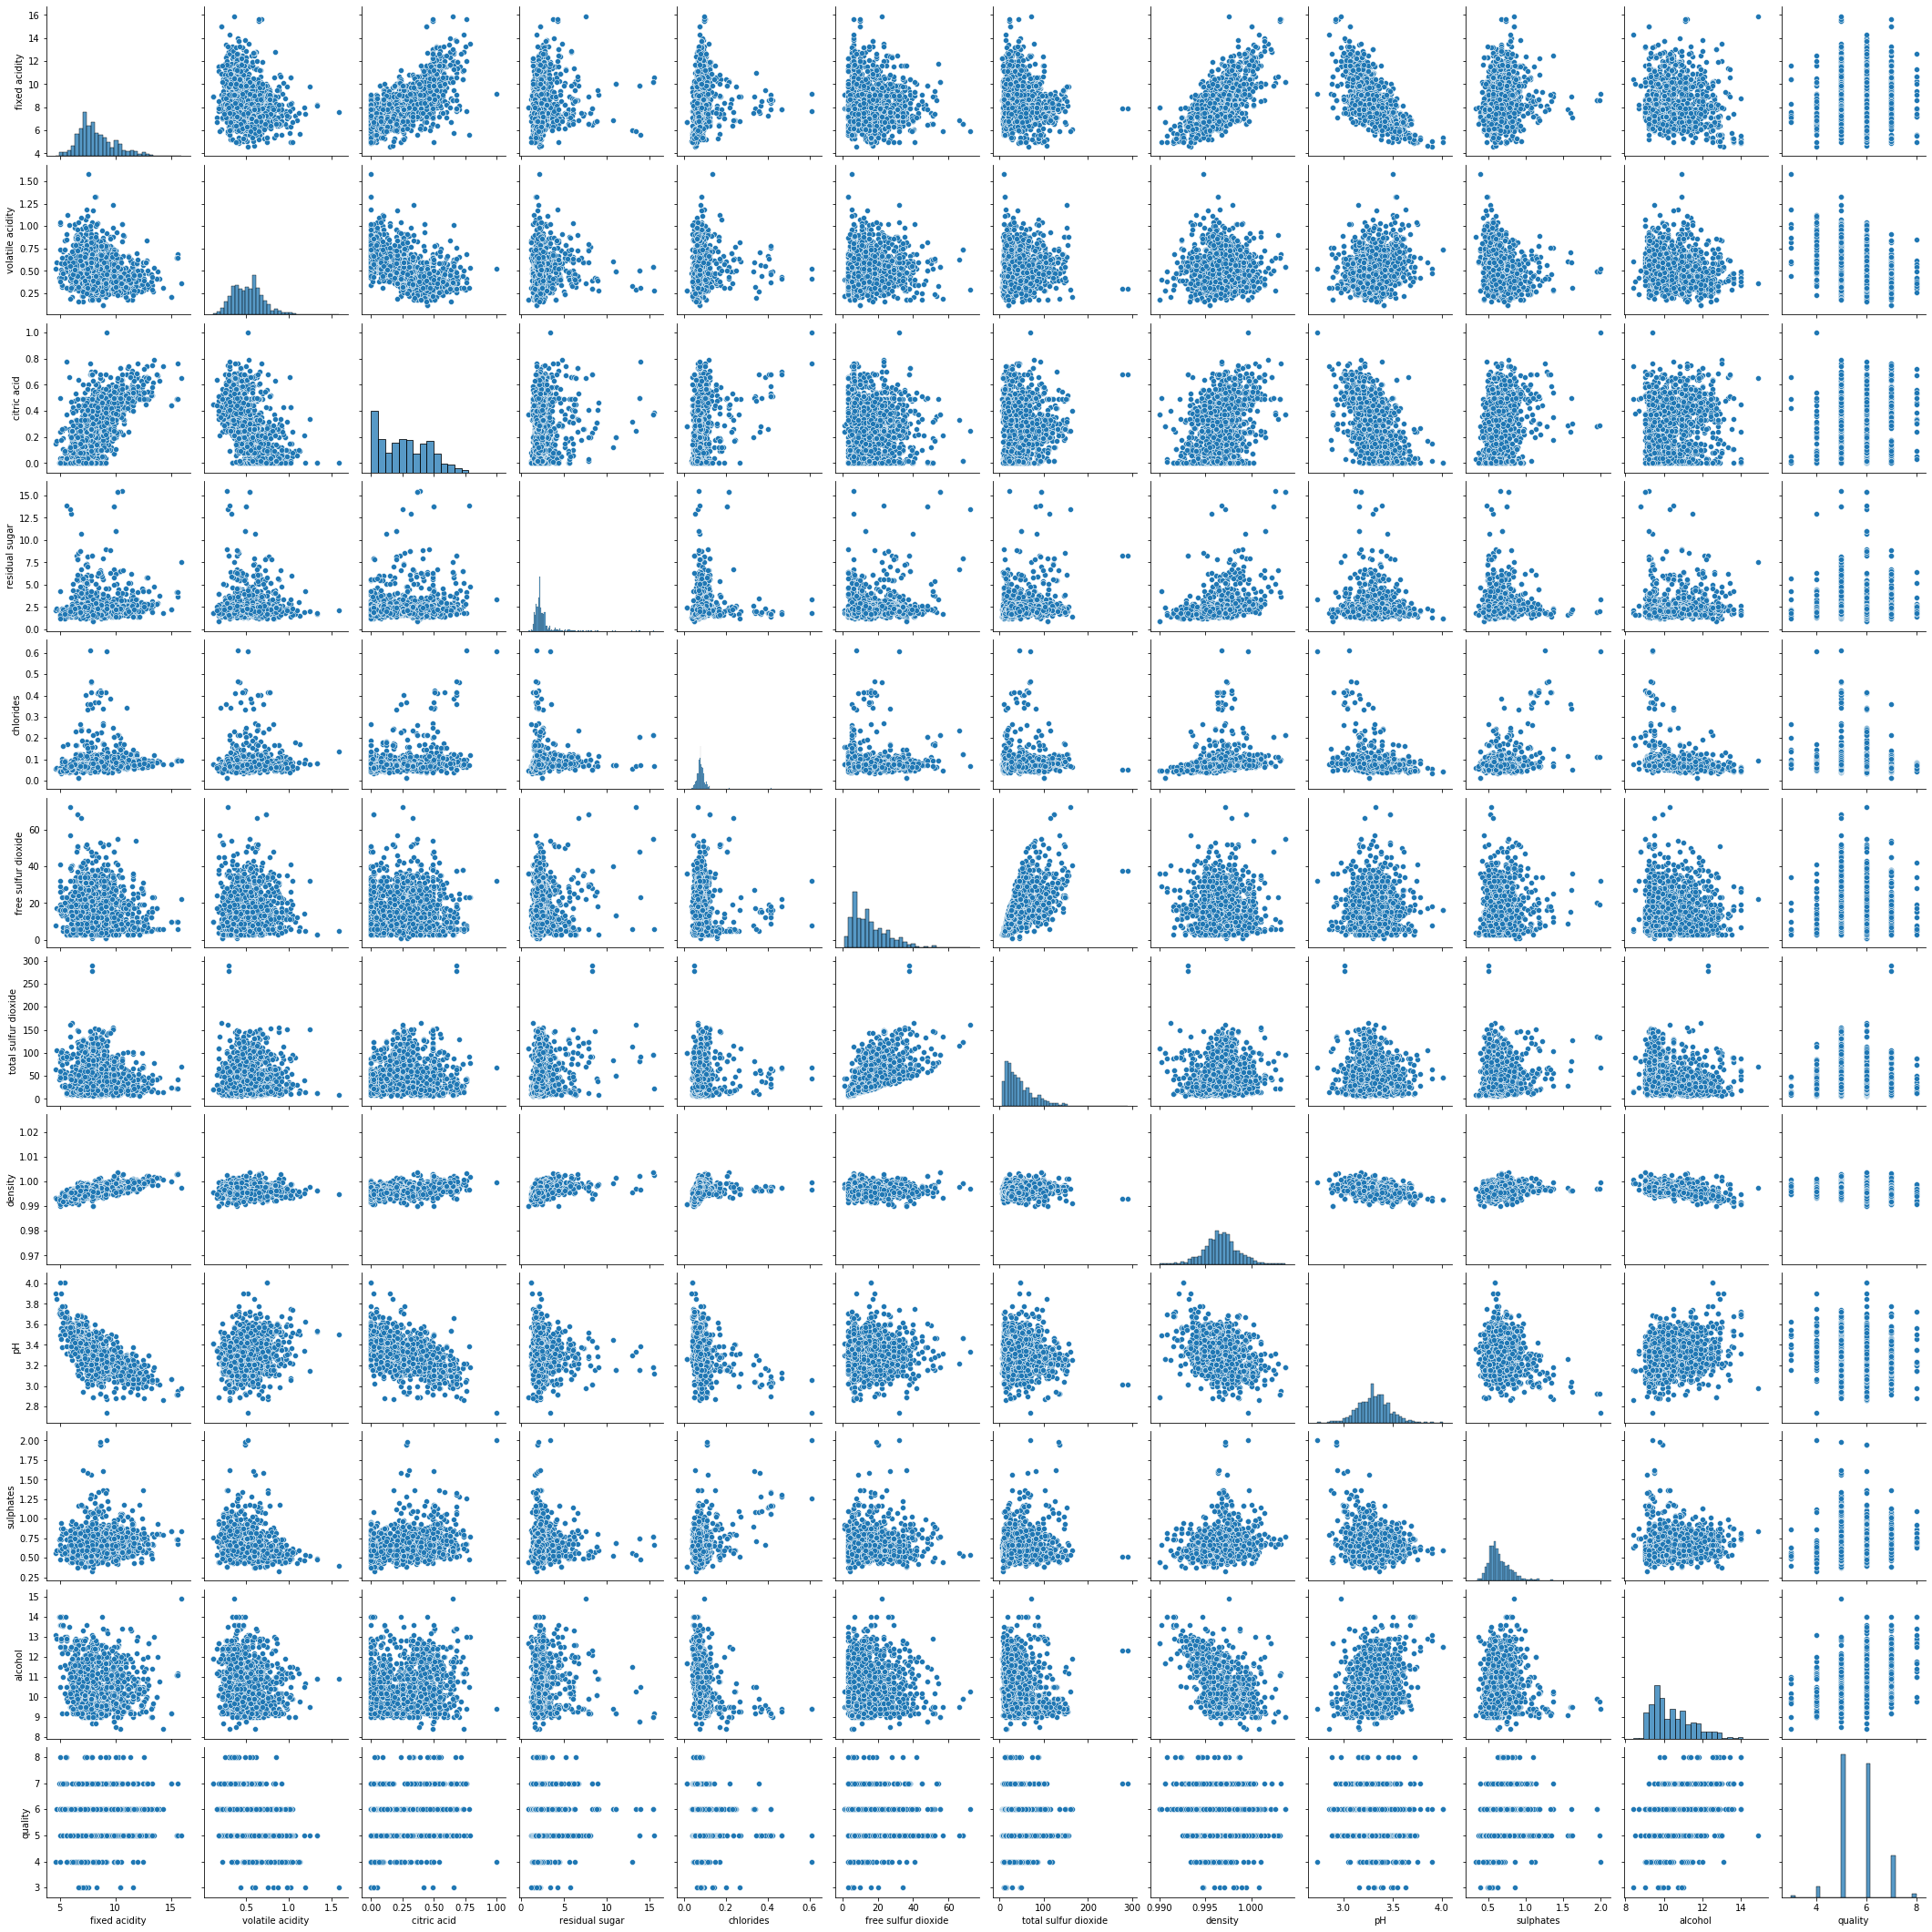

In [167]:
sns.pairplot(data)


#### As can be seen in the image, most of the features have positive skewness. Moreover, the amount of alcohol and the quality of the wine seem to have a direct proportion, which confirms common sense.

### The correlation matrix is evaluated on the heatmap shown below.

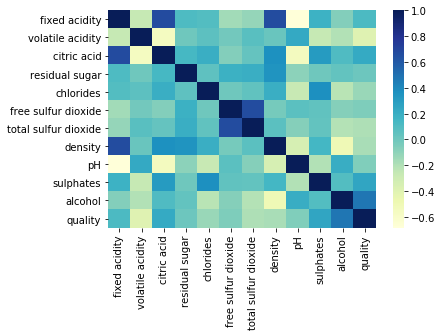

In [12]:
sns.heatmap(data.corr(), cmap="YlGnBu")

#### As can be seen, the density rises along with the fixed acidity, which in turn, is proportionally inverse to pH.



### Separating feature and label

In [540]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]


### Standardization

In [533]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))


### Analyzing principal components

In [526]:
pca = PCA()
x_components = pca.fit_transform(x)
x_components = pd.DataFrame(x_components)
eig_val_sum = sum(abs(np.diag(x_components.cov())))
np.diag(x_components.cov()/eig_val_sum)

array([0.28173931, 0.1750827 , 0.1409585 , 0.11029387, 0.08720837,
       0.05996439, 0.05307193, 0.03845061, 0.0313311 , 0.01648483,
       0.00541439])

#### Worth noting that the variance ratio is well distributed. So the main components do not describe the data well. 

### Labelling data considering only two categories of wine: Good (1) and Bad (0)

In [528]:
y = y.apply(lambda x: 1 if x>5 else 0)

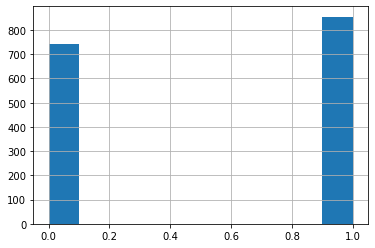

In [530]:
y.hist()

#### The data is slightly unbalanced

### Main processing:

In [529]:
folds = 5

kf = KFold(n_splits = folds, shuffle=True, random_state=0)
y_pred = np.ones(len(y))
acc = np.array([])
scores = np.array([])
for train_idx, test_idx in kf.split(x):
    x_train = x.loc[train_idx]
    y_train = y.loc[train_idx]

    x_test = x.loc[test_idx]
    y_test = y.loc[test_idx]
    
    model = RF()
    model.fit(x_train, y_train)
    
    pred = model.predict(x_test)
    y_pred[test_idx] = pred
    
    scores = np.append(scores, p_r_f_s(y, y_pred, average = 'binary'))
    acc = np.append(acc, accuracy_score(y_test, pred))
    
scores = scores.reshape(-1, 4)
print("Mean Accuracy: {:.2f}%".format(100 * acc.mean()))
print("Accuracy deviation: {:.2f}\n".format(acc.std()))

print("Mean Precision: {:.2f}%".format(100 * scores[:, 0].mean()))
print("Precision deviation: {:.2f}\n".format(scores[:, 0].std()))

print("Mean Recall: {:.2f}%".format(100 * scores[:, 1].mean()))
print("Recall deviation: {:.2f}\n".format(scores[:, 1].std()))

print("Mean F1 score: {:.2f}%".format(100 * scores[:, 2].mean()))
print("F1 score deviation: {:.2f}\n".format(scores[:, 2].std()))

print("Confusion Matrix:\n{}".format(conf(y, y_pred)))   

Mean Accuracy: 81.55%
Accuracy deviation: 0.02

Mean Precision: 68.23%
Precision deviation: 0.09

Mean Recall: 89.64%
Recall deviation: 0.05

Mean F1 score: 76.76%
F1 score deviation: 0.04

Confusion Matrix:
[[603 141]
 [154 701]]


### Since there are more good wines than bad wines in the database, the algorithm has a slight tendency to predict wines as good, scoring a low Precision. That occurs because precision decays when the number of false positives grows. 